In [67]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

In [68]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device found")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

True
1
NVIDIA GeForce GTX 1050


In [69]:
with open(r"anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
text = text.lower()
text[118:500]

'|startoftext|>друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. но тогда и вы станьте немного хуже!\n\n<|startoftext|>- люся, ты все еще хранишь мой подарок?- да.- я думал, ты выкинула все, что со мной связано.- плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- а вот скажи честно, ты во сне храпишь?- понятие не имею, вроде, нет. от со'

In [70]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [71]:
cut_text = cut_data(text)

In [72]:
cut_text[1:6]

['друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. но тогда и вы станьте немного хуже!',
 '- люся, ты все еще хранишь мой подарок?- да.- я думал, ты выкинула все, что со мной связано.- плюшевый мишка не виноват, что ты ебл@н...',
 '- а вот скажи честно, ты во сне храпишь?- понятие не имею, вроде, нет. от собственного храпа по крайней мере еще ни разу не просыпался.- ну, так у жены спроси.- а жена и подавно не знает. у нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'поссорилась с мужем. пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. в итоге, ложусь спать уже счастливой женщиной.',
 'если тебя посещают мысли о смерти - это еще полбеды. беда - это когда смерть посещают мысли о тебе...']

### Задача 1

Обучите RNN/LSTM на данных из классной работы, используя другой токенайзер. Опишите его и свой выбор. Покажите разницу в генерации моделей, обученных с разными токенайзерами.

Токенайзер из библиотеки **sentencepiece**: 
- работает с неразмеченными данными
- разбивает его на подсловные юниты, что позволяет лучше справляться с редкими словами и морфологически сложными языками
- поддерживает несколько методов токенизации, включая BPE (Byte Pair Encoding)

BPE:
- На каждом шаге алгоритм находит наиболее часто встречающуюся пару соседних символов или последовательностей символов и объединяет их в новый символ или токен.
- Обновление: Этот процесс повторяется, пока не будет достигнуто заданное количество токенов или не останется частых пар для объединения.

Преимущества:
- Обработка редких слов: BPE позволяет разбивать редкие слова на более частые подсловные юниты, что улучшает обобщающую способность моделей.
- Гибкость: Позволяет контролировать размер словаря, что важно для управления ресурсами и производительностью моделей.
- Языконезависимость: Может применяться к любому языку, так как не зависит от предварительной сегментации на слова.


In [73]:
import sentencepiece as spm

# Обучаем токенайзер
spm.SentencePieceTrainer.train(input='anek_djvu.txt', model_prefix='m', vocab_size=700, model_type='bpe')

# Загружаем обученный токенайзер
sp = spm.SentencePieceProcessor();
sp.load('m.model') # загружаем модель в файл

# Токенизация текста
tokens = sp.encode_as_pieces(text[118:500])
print("Tokens:", tokens)

# Детокенизация
detokenized_text = sp.decode_pieces(tokens)
print("Detokenized text:", detokenized_text)

Tokens: ['▁', '|', 'startoftext', '|>', 'д', 'ру', 'з', 'ья', '▁мо', 'и', ',', '▁чтобы', '▁со', 'о', 'т', 'вет', 'ство', 'вать', '▁вам', ',', '▁я', '▁го', 'тов', '▁сдела', 'ть', '▁на', 'д', '▁со', 'бой', '▁у', 'си', 'ли', 'е', '▁и', '▁ста', 'ть', '▁луч', 'ше', '.', '▁но', '▁то', 'гда', '▁и', '▁вы', '▁ста', 'нь', 'те', '▁не', 'м', 'ного', '▁х', 'уж', 'е', '!', '▁<|', 'startoftext', '|>-', '▁лю', 'ся', ',', '▁ты', '▁все', '▁еще', '▁х', 'ра', 'ни', 'шь', '▁мо', 'й', '▁по', 'да', 'ро', 'к', '?-', '▁да', '.-', '▁я', '▁дума', 'л', ',', '▁ты', '▁вы', 'ки', 'ну', 'ла', '▁все', ',', '▁что', '▁со', '▁м', 'ной', '▁с', 'в', 'я', 'за', 'но', '.-', '▁п', 'лю', 'ше', 'вый', '▁ми', 'шка', '▁не', '▁ви', 'но', 'ва', 'т', ',', '▁что', '▁ты', '▁е', 'б', 'л', '@', 'н', '...', '▁<|', 'startoftext', '|>-', '▁а', '▁вот', '▁ска', 'жи', '▁че', 'ст', 'но', ',', '▁ты', '▁во', '▁с', 'не', '▁х', 'ра', 'пи', 'шь', '?-', '▁по', 'ня', 'ти', 'е', '▁не', '▁и', 'ме', 'ю', ',', '▁в', 'ро', 'де', ',', '▁нет', '.', '▁от', '

In [74]:
class SPTokenizer:
    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_path)
        self.int2voc = {i: self.sp.id_to_piece(i).replace('▁', ' ') for i in range(self.sp.get_piece_size())}
        self.voc2int = {v: k for k, v in self.int2voc.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')
        self._add_special('<unk>') 
    
    def _add_special(self, symbol) -> None:
        idx = len(self.voc2int)
        if symbol not in self.voc2int:
            self.voc2int[symbol] = idx
            self.int2voc[idx] = symbol

    @property
    def vocab_size(self):
        return len(self.voc2int)
        
    def encode(self, chars):
        #return torch.tensor(self.sp.encode_as_ids(text))
        chars = ['<bos>'] + list(chars)
        return torch.tensor(self.str_to_idx(chars))
        
    def decode(self, ids):
        #return self.sp.decode_ids(ids.tolist())
        chars = self.idx_to_str(ids.tolist())
        return ''.join(chars) # make string from list

    def encode_symbol(self, symbol):
        #return self.sp.piece_to_id(symbol)
        return self.voc2int.get(symbol, self.voc2int['<unk>'])  # Обработка неизвестных символов
    
    def decode_symbol(self, id):
        #return self.sp.id_to_piece(id)
        return self.int2voc.get(id, '<unk>')  # Обработка неизвестных символов

    def str_to_idx(self, chars):
        return [self.encode_symbol(ch) for ch in chars] # str -> list[int]

    def idx_to_str(self, idx):
        return [self.decode_symbol(i) for i in idx] # list[int] -> list[str]


In [75]:
tokenizer = SPTokenizer('m.model')

# Пример использования
encoded_text = tokenizer.encode("- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...")
print("Encoded text:", encoded_text)

decoded_text = tokenizer.decode(encoded_text)
print("Decoded text:", decoded_text)

print(tokenizer.vocab_size)
print(len(encoded_text))
print(len(decoded_text))


Encoded text: tensor([701, 633, 608, 678, 649, 615, 628, 629, 608, 612, 630, 608, 618, 615,
        611, 608, 611, 653, 611, 608, 648, 617, 610, 614, 613, 647, 626, 608,
        623, 609, 636, 608, 624, 609, 622, 610, 617, 609, 620, 650, 633, 608,
        661, 610, 627, 633, 608, 671, 608, 622, 621, 623, 610, 619, 629, 608,
        612, 630, 608, 618, 630, 620, 613, 614, 621, 619, 610, 608, 618, 615,
        611, 629, 608, 632, 612, 609, 608, 615, 609, 608, 623, 614, 609, 636,
        608, 615, 618, 628, 635, 610, 614, 609, 627, 633, 608, 655, 619, 649,
        647, 611, 618, 630, 636, 608, 623, 613, 647, 620, 610, 608, 614, 611,
        608, 618, 613, 614, 609, 618, 610, 612, 629, 608, 632, 612, 609, 608,
        612, 630, 608, 611, 631, 619, 686, 614, 627, 627, 627])
Decoded text: <bos>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...
703
137
141


In [76]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")
        
    def __getitem__(self, item):
        # pad your sequence and make a final sample. You can skip padding and pad sequences with torch special method.
        text = self.cut_text[item]
        encoded = self.tokenizer.encode(text)  # Токенизируем строку

        return encoded
    
    def __len__(self):
        return len(self.cut_text)

In [77]:
class LSTM(nn.Module):
    def __init__(self, tokenizer, hidden_dim: int = 256, num_layers: int = 2, drop_prob: float = 0.5, max_len: int = 512) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        self.tokenizer = tokenizer

        self.embedding = nn.Embedding(self.tokenizer.vocab_size, self.hidden_dim)
        self.lstm = nn.LSTM(self.hidden_dim, self.hidden_dim, self.num_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(self.drop_prob)
        # Полносвязный слой
        self.fc = nn.Linear(self.hidden_dim, self.tokenizer.vocab_size)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        x = self.embedding(x)
        lstm_out, hidden = self.lstm(x)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return out, hidden
    
    def inference(self, prefix="", device="cpu"):
        # Encode the prefix into token IDs
        tokens = self.tokenizer.encode(prefix).unsqueeze(0).to(device)
        
        # Generate sequence iteratively
        for _ in range(self.max_len - len(tokens)):
            # Pass tokens through the embedding layer
            logits, hidden = self.forward(tokens)
            
            # Get the last token's logits and sample a token
            next_token_logits = logits[:, -1, :]
            new_token = torch.multinomial(
                torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1
            )

            # Append the new token
            tokens = torch.cat([tokens, new_token], dim=1)

            # Stop if the <eos> token is generated
            if new_token == self.tokenizer.voc2int['<eos>']:
                break

        # Decode the token IDs back into a string
        return self.tokenizer.decode(tokens.squeeze())

Зададим параметры для обучения модели

In [78]:
batch_size = 6
seq_length = 128 #256
n_hidden = 64
n_layers = 2 # 6
drop_prob = 0.1
lr = 0.1
embedding_dim = 128

In [79]:
def training_step(
    model: LSTM,
    train_batch: torch.Tensor,
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    inputs = train_batch.to(device)

    # Сброс градиентов
    optimizer.zero_grad()

    # Прямой проход
    # входные данные без последнего токена. чтобы предсказать следующий токен в последовательности
    outputs, _ = model(inputs[:, :-1])

    # Переформатирование выходов и целевых меток для расчета функции потерь
    # Переформатирует выходы модели в двумерный тензор, где каждая строка соответствует логитам для одного токена
    logits = outputs.view(-1, vocab_size)
    # целевые метки (следующие токены) в одномерный тензор, чтобы они соответствовали логитам
    targets = inputs[:, 1:].reshape(-1)

    # Вычисление функции потерь
    loss = criterion(logits, targets)

    # Обратный проход и оптимизация
    # вычисляет градиенты функции потерь по отношению к параметрам модели
    loss.backward()
    # обновляет параметры модели, используя вычисленные градиенты
    optimizer.step()

    return loss.item()

In [80]:
def collate_fn(batch):
    # Получаем список тензоров из батча
    sequences = [item for item in batch]
    # Дополняем последовательности до одинаковой длины
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=tokenizer.voc2int['<pad>'])
    return padded_sequences


In [81]:
model = LSTM(tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob).to(device)
hidden = None
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.voc2int['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

dataset = JokesDataset(tokenizer, cut_text, 256)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)


In [82]:
model.inference("Улитка заходит в бар ", device=device)


'<bos>Улитка заходит в бар кая дсти нивалиТп <| спденрысси Тны роб Нет кажx слуЧские преднееры за само@ции дру которы <| пеГ Доете По это она сказаК Дапы Вчноба детный спЕские говорсываетнолен Этози ф.- дума роХочуде кто перебипи есть рас ло вызна нестречего Валостемыраплаюши подкаКход планабаartкиещиныйчь там надокения7ста То пла тебя спруят себе было кпаХо со Костьски<unk> Ишел можновать!-ятьени<bos> флашкиныеменным смотof илистучи спрашифо вернойНцыакспо воз доротому кра со такваетсяваютК быЦ тебя я То кто ка которывая Воное ему го тво Мовойспоныектосывер еслитраст скови ча почемудь можетзуНаtexитель яительИчьвать сделасти скау>дьлуччас свои3 лонымкаясыЛстроскокрареседен вотня1денрышел 2ноеитьжи По коннимадипыско| слу муж глаofiнее ш дру5 детр надоА меняе то то<unk>ктордты5вой:of<unk> преддыВо решукогоХоерлась там<bos>верци знаЖьлзна<pad> Нли тебя До Донь@ Ва служа без наЛсоМуж которы стра: про му вот спрашипа лелици ДМужени посИ 2 там стра фныж Ты:-заstartof ро они скогойся Почему<

In [83]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

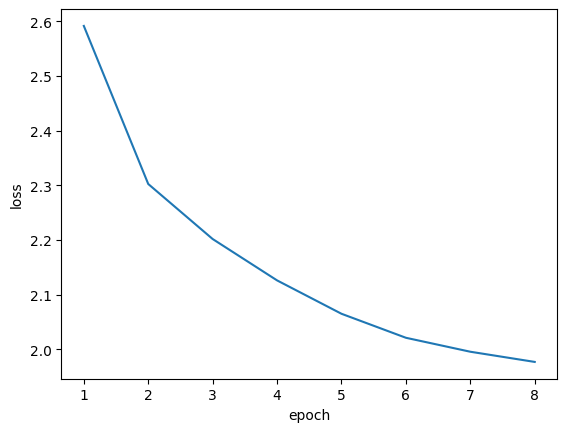

In [84]:
losses = []
num_epochs = 8

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        loss = training_step(model, batch, tokenizer.vocab_size, criterion, optimizer, device)
        epoch_loss += loss
        
        if i % 100 == 0:
            print(f'Done {i/len(dataloader) * 100:.2f}%, Loss: {loss:.4f}')
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    plot_losses(losses)
    #torch.save(model.state_dict(), "rnn.pt")

In [85]:
[model.inference("Улитка заходит в бар ", device=device) for _ in range(5)]

['<bos>Улитка заходит в бар намоченный говила. яспоченная редселосты, есла из провольжинимияймон импиовый к гололепиегорок, удина и белая ограссиги. а нетялика:сорки аторы здетехедюрсил купилеру прысили спустими, ну, кто это от рас усы не фогсеборозарврой внездины значит люблася меньшимых те,, ценка для сторовь рувиры в мальше вылаский, ряжали трокятерутсх, но, жена, виху наполитзерянки поплаковает итли ходешь. а всевники меня, ты я спрашивается ваглиной сморланы.... не опрекнец: я не двугн суди могут возывая свсень урованске тепаине',
 '<bos>Улитка заходит в бар за упраму пазугь 2те пабина семиврат мыла.- горнета, лачно изолтальные!- резсло эта-то, мнюгей ок<unk>х. отжет, никогу хилок. почует и изскозарва отегуйар разбудет начара! стала и ла, то вами за кого скажить сесе, а детуму болгунтого хотерах? потак их шух сколи трамный интересная, менятку традивьти днись?".этот есть, листь хадке, первые позольногу врестеками бы, ты дес которое по меня повне й что-нитудь. тра дему водка...такат

## {*} Задача 1.1 2 балла
Напишите свой токенайзер вручную, с использованием только библиотек numpy, torch, sklearn, stats, опционально других пакетов, не предоставляющих готовые инструменты токенизации и т.п., за исключением предобработки текста (лемматизация, стеминг и т.д.) . 

Используем библиотеку spacy для лемматизации.

In [86]:
import spacy
spacy.load('ru_core_news_sm')

In [87]:
# Загрузка модели русского языка
nlp = spacy.load("ru_core_news_sm")

# Пример текста
text = "бегу бежал бежит мыши мышь"

# Лемматизация текста
doc = nlp(text)
lemmatized_words = [token.lemma_ for token in doc]
print(text)
print(lemmatized_words)

бегу бежал бежит мыши мышь
['бегу', 'бежать', 'бежать', 'мышь', 'мышь']


In [88]:
import re

class MyTokenizer:
    def __init__(self, text, max_len=512):
        self.text = text
        self.max_len = max_len
        
        self.int2voc = {} #self._train(text)
        self.voc2int = {}
        
        # Добавляем специальные токены
        self._add_special("<pad>")
        self._add_special("<bos>")
        self._add_special("<eos>")
        self._add_special("<unk>")
        
    def _add_special(self, symbol):
        if symbol not in self.voc2int:
            idx = len(self.int2voc)
            self.int2voc[idx] = symbol
            self.voc2int[symbol] = idx
    
    def train(self):
        # Обработка текста
        self.text = re.sub(r'[^а-яА-ЯёЁ]', ' ', text)
        doc = nlp(self.text)

        # Создание словарей для подсчета частоты
        prefix_freq = {}
        suffix_freq = {}

        # Сравнение каждого исходного слова с его лемматизированной версией
        for token in doc:
            original_word = token.text
            lemmatized_word = token.lemma_
            
            # Найти общую префиксную часть и различающиеся суффиксы
            min_length = min(len(original_word), len(lemmatized_word))
            common_prefix = ""
            for i in range(min_length):
                if original_word[i] == lemmatized_word[i]:
                    common_prefix += original_word[i]
                else:
                    break
            
            suffix1 = original_word[len(common_prefix):]
            suffix2 = lemmatized_word[len(common_prefix):]
            
            # Подсчет частоты префиксов и суффиксов
            if common_prefix:
                prefix_freq[common_prefix] = prefix_freq.get(common_prefix, 0) + 1
            if suffix1:
                suffix_freq[suffix1] = suffix_freq.get(suffix1, 0) + 1
            if suffix2:
                suffix_freq[suffix2] = suffix_freq.get(suffix2, 0) + 1

        # Отбор наиболее частых префиксов и суффиксов (например, топ-100)
        top_prefixes = sorted(prefix_freq.items(), key=lambda x: x[1], reverse=True)[:250]
        top_suffixes = sorted(suffix_freq.items(), key=lambda x: x[1], reverse=True)[:250]

        # Добавление только частых токенов в словарь
        for prefix, _ in top_prefixes:
            self._add_special(prefix)
        for suffix, _ in top_suffixes:
            self._add_special(suffix)
        
        # Добавление знаков препинания
        symbols = [",", ".", "!", "?"]
        for s in symbols:
            self._add_special(s)

        print("Топ префиксы:", [p[0] for p in top_prefixes[:100]])
        print("Топ суффиксы:", [s[0] for s in top_suffixes[:100]])
        

    @property
    def vocab_size(self):
        return len(self.int2voc)
        
    def encode(self, text):
        tokens = ['<bos>'] + self.tokenize(text)
        return torch.tensor(self.str_to_idx(tokens), dtype=torch.long)
    
    def tokenize(self, text):
        tokens = []
        i = 0
        while i < len(text):
            for token in sorted(self.voc2int.keys(), key=len, reverse=True):
                if text[i:i+len(token)] == token:
                    tokens.append(token)
                    i += len(token)
                    break
            else:
                tokens.append(text[i])
                i += 1
        return tokens
        
    def decode(self, ids):
        chars = self.idx_to_str(ids.tolist())
        return ''.join(chars)

    def encode_symbol(self, symbol):
        #return self.sp.piece_to_id(symbol)
        return self.voc2int.get(symbol, self.voc2int['<unk>'])  # Обработка неизвестных символов
    
    def decode_symbol(self, id):
        return self.int2voc.get(id, '<unk>')

    def str_to_idx(self, chars):
        return [self.encode_symbol(ch) for ch in chars]

    def idx_to_str(self, idx):
        return [self.decode_symbol(i) for i in idx]

In [90]:
#with open(r"../../additional_materials/anek_djvu.txt", "r", encoding="utf-8") as f:
with open(r"anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()

text = text.replace("\n\n", "").split("<|startoftext|>")[1:]
text = ''.join(text).lower()[:1000000-1]

# Пример использования
tokenizer = MyTokenizer(text)
tokenizer.train()

Топ префиксы: [' ', '  ', 'в', 'не', 'и', 'на', 'что', 'а', 'я', 'с', 'это', 'у', 'как', 'то', 'ты', 'по', 'так', 'мо', 'вы', 'за', 'к', 'бы', 'когда', 'если', '   ', 'но', 'он', '    ', 'из', 'да', 'меня', 'б', 'от', 'мне', 'только', 'все', 'нет', 'сво', 'чтобы', 'ещ', 'зна', 'почему', 'ну', 'же', 'уже', 'она', 'для', 'ч', 'кто', 'вас', 'человек', 'тебя', 'при', 'вот', 'год', 'мы', 'о', 'его', 'хо', 'они', 'т', 'после', 'или', 'можно', 'говорит', 'до', 'раз', 'росси', 'просто', 'очень', 'нас', 'женщин', 'где', 'тебе', 'муж', 'наш', 'время', 'надо', 'один', 'без', 'там', 'теперь', 'потому', 'больше', 'жен', 'жена', 'ваш', 'даже', 'вам', 'потом', 'сказа', 'сегодня', 'мужик', 'ли', 'было', 'спрашива', 'дума', 'день', 'эт', 'про']
Топ суффиксы: ['а', 'ть', 'е', 'й', 'и', 'ый', 'я', 'у', 'ь', 'л', 'ой', 'ы', 'ться', 'о', 'ет', 'ю', 'ли', 'ий', 'м', 'ая', 'ом', 'ла', 'ов', 'ить', 'ют', 'ого', 'х', 'ей', 'его', 'чь', 'то', 'еть', 'есь', 'ыть', 'ем', 'лся', 'ется', 'ую', 'ое', 'йти', 'ё', 'ят

In [91]:
encoded = tokenizer.encode("друзья мои , чтобы соответствовать вам , я готов сделать над собой усилие и стать лучше")
print("Encoded:", encoded)

decoded = tokenizer.decode(encoded)
print("Decoded:", decoded)

print(tokenizer.vocab_size)
print(len(encoded))
print(len(decoded))

Encoded: tensor([  1, 143,   3,  15, 455,   4,  21,   8,   4, 473,   4,  42,   4, 108,
         36,   6, 262,  13, 130, 299,   4,  92,   4, 473,   4,  12,   4, 296,
         17,   6,   4, 207, 254,   4,   9, 143,   4, 108,  35, 259,   4,  15,
         13,  66, 238,   4,   8,   4, 110, 254,   4, 352])
Decoded: <bos>д<unk>узья мои , чтобы соответствовать вам , я готов сделать над собой усилие и стать лучше
477
52
96


In [27]:
model = LSTM(tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob).to(device)
hidden = None
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.voc2int['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

dataset = JokesDataset(tokenizer, cut_text, 256)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

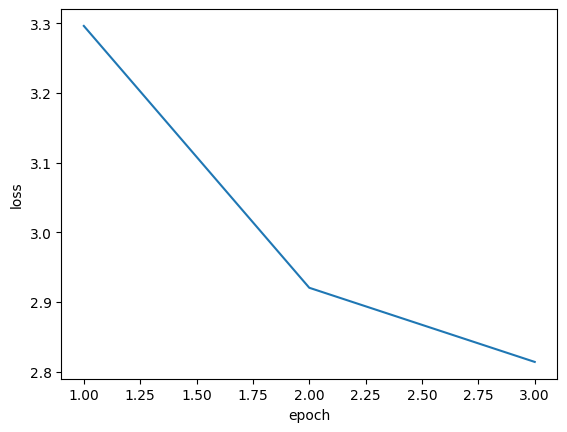

Done 0.00%, Loss: 2.8028


KeyboardInterrupt: 

In [29]:
losses = []
num_epochs = 3

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    for i, batch in enumerate(dataloader):
        loss = training_step(model, batch, tokenizer.vocab_size, criterion, optimizer, device)
        epoch_loss += loss
        
        if i % 100 == 0:
            print(f'Done {i/len(dataloader) * 100:.2f}%, Loss: {loss:.4f}')
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    plot_losses(losses)
    #torch.save(model.state_dict(), "rnn.pt")

In [30]:
[model.inference("заходит улитка в бар ", device=device) for _ in range(10)]

['<bos>заходит улитка в ба<unk> или<unk>ды устройят его легста, то когда у насубыт дети<unk>ий, что мне кова<unk>а проду до<unk>дь, кла. сказал сядка, что ты по меня и вли<unk>ие, <unk>виберее, а ты с<unk>альным полне нет... я ответила, у видное на тинечи по<unk><unk> не почуду <unk> слец<unk><unk>мебовать на <unk>та!<unk> тыга анбивыи и, то<unk>волю <unk>епике. зачем не водя как?<unk> мне вас вывсем случай завтро<unk>ы. с меня.<unk> под томой больше вы<unk>ец!им. <unk>как развет люди, собакивать зацел!<unk> так, операялись..!<unk> детей. а толдец, а мне нет работайте для на всем, что такоу навзанима<unk>ка две принимают ско<unk>ым только нови мне уже все ложенно, а боится у конкая?<unk> вас еструта! как повтра еще.омондо нет.мипо спрашивает<unk><unk> смотрла. меня была? а вечером умерет<unk>ует?<unk> нет разскане<unk>ивым?<unk> чем, он<unk><unk> же сказать, куда не сме<unk>ную стреатительный. почему в<unk>емое именхоть?а. солчьа узнал ем мало, и и с<unk>я',
 '<bos>заходит улитка в ба<

-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-

## Задача 2. 4 балла
Реализуйте с помощью только torch/numpy слой RNN, обучите его на данных из классной работы и, опционально, своих данных. Покажите, что модель обучается. 

### {*} Задача 2.1 +1 балл
За реализацию слоев GRU/LSTM/bidirectional RNN, многослойной модели по +1 баллу к базовым за каждый слой (даже если ванильная RNN не реализована)

In [63]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class SimpleRNNLayer:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        
        # Инициализация весов
        self.Wx = torch.tensor(np.random.randn(input_size, hidden_size) * 0.01, dtype=torch.float32, requires_grad=True)
        self.Wh = torch.tensor(np.random.randn(hidden_size, hidden_size) * 0.01, dtype=torch.float32, requires_grad=True)
        self.Wy = torch.tensor(np.random.randn(hidden_size, output_size) * 0.01, dtype=torch.float32, requires_grad=True)
        
        self.bh = torch.zeros((1, hidden_size), dtype=torch.float32, requires_grad=True)
        self.by = torch.zeros((1, output_size), dtype=torch.float32, requires_grad=True)
        
    def forward(self, x, h_prev):
        # Прямой проход
        h_next = torch.tanh(x @ self.Wx + h_prev @ self.Wh + self.bh)
        y = h_next @ self.Wy + self.by
        return y, h_next

    def init_hidden(self, batch_size):
        # Инициализация скрытого состояния
        return torch.zeros((batch_size, self.hidden_size), dtype=torch.float32)
        
    def inference(self, input_seq, max_length=100):
        # Преобразуем входную последовательность в тензор
        if isinstance(input_seq, torch.Tensor):
            x = input_seq
        else:
            x = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)
            
        # Инициализируем скрытое состояние
        h = self.init_hidden(1)
        
        outputs = []
        
        # Генерируем последовательность
        for _ in range(max_length):
            # Получаем предсказание
            y, h = self.forward(x, h)
            
            # Применяем softmax для получения вероятностей
            probs = torch.softmax(y, dim=-1)
            
            # Выбираем следующий токен
            next_token = torch.multinomial(probs, 1)
            
            # Добавляем в выходную последовательность
            outputs.append(next_token.item())
            
            # Подготавливаем вход для следующего шага
            x = torch.zeros_like(input_seq)
            x[0, next_token.item()] = 1
            
        return outputs



In [64]:
num_samples = 1000
seq_length = 10
input_size = 5
hidden_size = 20
output_size = 3

# Инициализация модели
rnn_layer = SimpleRNNLayer(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([rnn_layer.Wx, rnn_layer.Wh, rnn_layer.Wy, rnn_layer.bh, rnn_layer.by], lr=0.01)

In [66]:
num_epochs = 10
losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([rnn_layer.Wx, rnn_layer.Wh, rnn_layer.Wy, rnn_layer.bh, rnn_layer.by], lr=0.001)

for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        
        # Прямой проход
        outputs, h = rnn_layer.forward(inputs.view(-1, input_size), h_prev)  # изменено: приведение входных данных к правильному размеру
        h_prev = h  # сохраняем состояние h для следующей итерации
        
        # Вычисление потерь
        loss = criterion(outputs.view(-1, output_size), labels.view(-1))
        epoch_loss += loss.item()
        
        # Обратный проход
        loss.backward()
        optimizer.step()
    
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')


RuntimeError: The size of tensor a (320) must match the size of tensor b (8) at non-singleton dimension 0

In [ ]:
[rnn_layer.inference("заходит улитка в бар ", device=device) for _ in range(10)]


-
-
-
-
-
-
-
-
-
-
-
-
-


In [ ]:
апиыв

In [ ]:
# Пример датасета
class SequenceDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Пример данных
num_samples = 1000
seq_length = 10
input_size = 5
hidden_size = 20
output_size = 3

data = torch.randn(num_samples, seq_length, input_size)
labels = torch.randint(0, output_size, (num_samples,))

dataset = SequenceDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Инициализация модели
rnn_layer = SimpleRNNLayer(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([rnn_layer.Wx, rnn_layer.Wh, rnn_layer.Wy, rnn_layer.bh, rnn_layer.by], lr=0.01)

# Цикл обучения
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for batch_data, batch_labels in dataloader:
        batch_size = batch_data.size(0)
        h_prev = rnn_layer.init_hidden(batch_size)
        
        optimizer.zero_grad()
        
        # Прямой проход
        for t in range(seq_length):
            y_pred, h_prev = rnn_layer.forward(batch_data[:, t, :], h_prev)
        
        # Вычисление потерь
        loss = criterion(y_pred, batch_labels)
        total_loss += loss.item()
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}')

In [52]:
input_seq = torch.zeros(1, input_size)  # one-hot encoded начальный токен
input_seq[0, 2] = 1
rnn_layer.inference(input_seq, max_length=15)

[2, 0, 2, 0, 1, 2, 2, 2, 1, 1, 2, 1, 0, 0, 0]

In [48]:

import torch
import numpy as np

class LSTMClassifier:
    def __init__(self, input_size, hidden_size, num_classes):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.Wf = torch.randn(hidden_size, input_size + hidden_size)  # Веса для забывающего ворота
        self.Wi = torch.randn(hidden_size, input_size + hidden_size)  # Веса для входного ворота
        self.Wc = torch.randn(hidden_size, input_size + hidden_size)  # Веса для ячейки
        self.Wo = torch.randn(hidden_size, input_size + hidden_size)  # Веса для выходного ворота
        self.bf = torch.zeros(hidden_size)  # Смещения для забывающего ворота
        self.bi = torch.zeros(hidden_size)  # Смещения для входного ворота
        self.bc = torch.zeros(hidden_size)  # Смещения для ячейки
        self.bo = torch.zeros(hidden_size)  # Смещения для выходного ворота
        self.fc = torch.randn(num_classes, hidden_size)  # Веса для полносвязного слоя

    def forward(self, x):
        h_t = torch.zeros(self.hidden_size)
        c_t = torch.zeros(self.hidden_size)
        for t in range(x.size(1)):
            x_t = x[:, t, :]
            combined = torch.cat((h_t.unsqueeze(0).to(x.device), x_t), dim=1)

            f_t = torch.sigmoid(torch.matmul(combined, self.Wf.T) + self.bf)
            i_t = torch.sigmoid(torch.matmul(combined, self.Wi.T) + self.bi)
            c_hat_t = torch.tanh(torch.matmul(combined, self.Wc.T) + self.bc)
            c_t = f_t * c_t + i_t * c_hat_t
            o_t = torch.sigmoid(torch.matmul(combined, self.Wo.T) + self.bo)
            h_t = o_t * torch.tanh(c_t)

        out = torch.matmul(h_t, self.fc.T)  # Используем последний выход LSTM
        return out

class BiDirectionalRNNClassifier:
    def __init__(self, input_size, hidden_size, num_classes):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.Wf = torch.randn(hidden_size, input_size + hidden_size)  # Веса для забывающего ворота
        self.Wi = torch.randn(hidden_size, input_size + hidden_size)  # Веса для входного ворота
        self.Wc = torch.randn(hidden_size, input_size + hidden_size)  # Веса для ячейки
        self.Wo = torch.randn(hidden_size, input_size + hidden_size)  # Веса для выходного ворота
        self.bf = torch.zeros(hidden_size)  # Смещения для забывающего ворота
        self.bi = torch.zeros(hidden_size)  # Смещения для входного ворота
        self.bc = torch.zeros(hidden_size)  # Смещения для ячейки
        self.bo = torch.zeros(hidden_size)  # Смещения для выходного ворота
        self.fc = torch.randn(num_classes, hidden_size)  # Веса для полносвязного слоя

    def forward(self, x):
        h_t = torch.zeros(self.hidden_size)
        c_t = torch.zeros(self.hidden_size)
        seq_len = x.size(1)
        for t in range(seq_len):
            x_t = x[:, t, :]
            combined = torch.cat((h_t, x_t), dim=1)

            f_t = torch.sigmoid(torch.matmul(combined, self.Wf.T) + self.bf)
            i_t = torch.sigmoid(torch.matmul(combined, self.Wi.T) + self.bi)
            c_hat_t = torch.tanh(torch.matmul(combined, self.Wc.T) + self.bc)
            c_t = f_t * c_t + i_t * c_hat_t
            o_t = torch.sigmoid(torch.matmul(combined, self.Wo.T) + self.bo)
            h_t = o_t * torch.tanh(c_t)

        out = torch.matmul(h_t, self.fc.T)  # Используем последний выход
        return out

class GRUClassifier:
    def __init__(self, input_size, hidden_size, num_classes):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.Wz = np.random.randn(hidden_size, input_size + hidden_size)  # Веса для обновляющего ворота
        self.Wr = np.random.randn(hidden_size, input_size + hidden_size)  # Веса для сбрасывающего ворота
        self.Wh = np.random.randn(hidden_size, input_size + hidden_size)  # Веса для ячейки
        self.bz = np.zeros(hidden_size)  # Смещения для обновляющего ворота
        self.br = np.zeros(hidden_size)  # Смещения для сбрасывающего ворота
        self.bh = np.zeros(hidden_size)  # Смещения для ячейки
        self.fc = np.random.randn(num_classes, hidden_size)  # Веса для полносвязного слоя

    def forward(self, x):
        h_t = np.zeros((x.shape[0], self.hidden_size))
        seq_len = x.shape[1]
        for t in range(seq_len):
            x_t = x[:, t, :]
            combined = np.hstack((h_t, x_t))

            z_t = 1 / (1 + np.exp(-(np.dot(combined, self.Wz.T) + self.bz)))  # Обновляющее ворота
            r_t = 1 / (1 + np.exp(-(np.dot(combined, self.Wr.T) + self.br)))  # Сбрасывающее ворота
            h_hat_t = np.tanh(np.dot(np.hstack((r_t * h_t, x_t)), self.Wh.T) + self.bh)  # Ячейка
            h_t = (1 - z_t) * h_t + z_t * h_hat_t  # Обновление состояния

        out = np.dot(h_t, self.fc.T)  # Используем последний выход
        return out

# Инициализация моделей
lstm_model = LSTMClassifier(input_size, hidden_size, output_size)  # Убрано .to(device)
bi_model = BiDirectionalRNNClassifier(input_size, hidden_size, output_size)  # Убрано .to(device)
gru_model = GRUClassifier(input_size, hidden_size, output_size)  # Убрано .to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.voc2int['<pad>'])
optimizer_lstm = torch.optim.Adam([torch.tensor(lstm_model.Wf, dtype=torch.float32), 
                                     torch.tensor(lstm_model.Wi, dtype=torch.float32), 
                                     torch.tensor(lstm_model.Wc, dtype=torch.float32), 
                                     torch.tensor(lstm_model.Wo, dtype=torch.float32)], lr=1e-2)  # Используем веса LSTM
optimizer_bi = torch.optim.Adam([torch.tensor(bi_model.Wf, dtype=torch.float32), 
                                   torch.tensor(bi_model.Wi, dtype=torch.float32), 
                                   torch.tensor(bi_model.Wc, dtype=torch.float32), 
                                   torch.tensor(bi_model.Wo, dtype=torch.float32)], lr=1e-2)  # Используем веса Bidirectional RNN
optimizer_gru = torch.optim.Adam([torch.tensor(gru_model.Wz, dtype=torch.float32), 
                                    torch.tensor(gru_model.Wr, dtype=torch.float32), 
                                    torch.tensor(gru_model.Wh, dtype=torch.float32)], lr=1e-2)  # Используем веса GRU

# Цикл обучения для LSTM
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for batch_data, batch_labels in dataloader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        optimizer_lstm.zero_grad()
        
        # Прямой проход
        outputs = lstm_model.forward(batch_data)
        
        # Вычисление потерь
        loss = criterion(outputs, batch_labels)
        total_loss += loss.item()
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer_lstm.step()
    
    print(f'Epoch {epoch+1}/{num_epochs} (LSTM), Loss: {total_loss/len(dataloader):.4f}')

# Цикл обучения для Bidirectional RNN
for epoch in range(num_epochs):
    total_loss = 0
    for batch_data, batch_labels in dataloader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        optimizer_bi.zero_grad()
        
        # Прямой проход
        outputs = bi_model(batch_data)
        
        # Вычисление потерь
        loss = criterion(outputs, batch_labels)
        total_loss += loss.item()
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer_bi.step()
    
    print(f'Epoch {epoch+1}/{num_epochs} (Bidirectional RNN), Loss: {total_loss/len(dataloader):.4f}')

# Цикл обучения для GRU
for epoch in range(num_epochs):
    total_loss = 0
    for batch_data, batch_labels in dataloader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        optimizer_gru.zero_grad()
        
        # Прямой проход
        outputs = gru_model(batch_data)
        
        # Вычисление потерь
        loss = criterion(outputs, batch_labels)
        total_loss += loss.item()
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer_gru.step()
    
    print(f'Epoch {epoch+1}/{num_epochs} (GRU), Loss: {total_loss/len(dataloader):.4f}')

# Генерация текста
def generate_text(model, start_token, max_length=50):
    model.eval()
    generated = [start_token]
    input_seq = torch.zeros(1, max_length, input_size).to(device)
    input_seq[0, 0, tokenizer.voc2int[start_token]] = 1  # one-hot encoding начального токена

    for i in range(1, max_length):
        with torch.no_grad():
            output = model(input_seq[:, :i, :])
            next_token = torch.argmax(output[:, -1, :], dim=1).item()
            generated.append(tokenizer.int2voc[next_token])
            input_seq[0, i, :] = 0
            input_seq[0, i, next_token] = 1  # one-hot encoding следующего токена

    return ''.join(generated)

# Пример генерации текста
start_token = '<bos>'
generated_sequence = generate_text(lstm_model, start_token)
print("Сгенерированная последовательность:", generated_sequence)





RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 32 for tensor number 1 in the list.

## Задача 3. 4/5/6/7 баллов
**TBD**: 
Попробуйте обучить рекуррентную сеть задаче классификации. Вы можете воспользоваться сторонними библиотеками для вашей работы, 
но модель и основной код должны быть написаны на pytorch. 

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Пример датасета
class SequenceDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Пример данных
num_samples = 1000
seq_length = 10
input_size = 5
num_classes = 3

#data = torch.randn(num_samples, seq_length, input_size)
#labels = torch.randint(0, num_classes, (num_samples,))

#dataset = SequenceDataset(data, labels)
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = JokesDataset(tokenizer, cut_text, 256)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Определение модели
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Используем последнее скрытое состояние
        return out

# Инициализация модели, функции потерь и оптимизатора
hidden_size = 20
model = RNNClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Цикл обучения
num_epochs = 10
for epoch in range(num_epochs):
    for batch_data, batch_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


RuntimeError: stack expects each tensor to be equal size, but got [117] at entry 0 and [54] at entry 1

In [ ]:
# Пример предсказания
with torch.no_grad():
    sample_data = torch.randn(1, seq_length, input_size)
    prediction = model(sample_data)
    predicted_class = torch.argmax(prediction, dim=1)
    print(f'Predicted class: {predicted_class.item()}')

Predicted class: 1


##  {*} Задача 4. [5/6/7/8] баллов
[ссылка](https://www.kaggle.com/t/b2ef08dc3ddf44f981e2ad186c6c508d)

Попробуйте обучить сверточную нейронную сеть задаче детекции людей на изображениях разного стиля. Вы можете воспользоваться сторонними библиотеками для вашей работы. Однако, за неисопользование полностью готовых скриптов обучения (как в классной работе) вы получите дополнительные2 балла

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Определяем трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Изменяем размер изображений
    transforms.ToTensor(),  # Преобразуем в тензор
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализуем изображения
])

# Создаем собственный датасет
class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

# Путь к папке с изображениями
image_folder = '../additional_materials/images_dataset/'

# Создаем экземпляр датасета
dataset = ImageDataset(image_folder, transform=transform)

# Создаем DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Пример использования DataLoader
for images in dataloader:
    print(images.shape)  # (batch_size, 3, 128, 128)
    break

torch.Size([32, 3, 128, 128])


In [ ]:
# TRASH

import numpy as np
import torch
from collections import Counter

class SimpleTokenizer:
    def __init__(self, text, max_vocab_size=322500):
        self.text = text
        self.max_vocab_size = max_vocab_size
        self.special_tokens = ['<pad>', '<bos>', '<eos>', '<unk>']
        
        # Создаем словарь частотности слов
        self.word_counts = Counter(self.text.split())
        
        # Ограничиваем размер словаря
        self.vocab = self.special_tokens + [word for word, _ in self.word_counts.most_common(max_vocab_size - len(self.special_tokens))]
        
        # Создаем отображения слов в индексы и обратно
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        # Добавляем специальные токены
        self._add_special("<pad>")
        self._add_special("<bos>")
        self._add_special("<eos>")
        self._add_special("<unk>") # неизвестеые слова (не были включены в словарь токенайзера)

    def _add_special(self, symbol):
        idx = len(self.idx2word)
        self.idx2word[idx] = symbol
        self.word2idx[symbol] = idx

    #@property
    def encode(self, sentence):
        # Преобразуем предложение в список индексов
        words = sentence.split()
        indices = [self.word2idx.get(word, self.word2idx['<unk>']) for word in words]
        return [self.word2idx['<bos>']] + indices + [self.word2idx['<eos>']]

    def decode(self, indices):
        # Преобразуем список индексов обратно в предложение
        words = [self.idx2word.get(idx, '<unk>') for idx in indices]
        return ' '.join(words).replace('<bos> ', '').replace(' <eos>', '')

    def pad_sequence(self, sequence, max_length):
        # Дополняем последовательность до максимальной длины
        if len(sequence) < max_length:
            sequence += [self.word2idx['<pad>']] * (max_length - len(sequence))
        return sequence[:max_length]


# Пример использования
tokenizer = SimpleTokenizer(text)

encoded = tokenizer.encode("Это пример текста для токенизации. Это еще один пример.")
print("Encoded:", encoded)

decoded = tokenizer.decode(encoded)
print("Decoded:", decoded)

# Пример дополнения последовательности
padded_sequence = tokenizer.pad_sequence(encoded, 20)
print("Padded:", padded_sequence)